In [1]:
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import math


In [3]:
# 
# Input data are in individual tab-delimited files, one for each experiment
# Here I load each one into its own Pandas dataframe and create a list of frames
#

frames = []

for file in os.listdir("Data"):
    if file.endswith(".gbgout"):
        filepath = os.path.join("Data/", file)
        fs = file.split('_')
        name = "_".join(fs[0:2])
        frames.append(pd.read_csv(filepath, sep="\t", header = None, names=['Gene',name]))

In [4]:
#
# Combines all of the individual frames into one dataframe, combining on the "Gene" column
# Column names are the data file
#

df = reduce(lambda  left,right: pd.merge(left,right,on=['Gene'], how='outer'), frames)

In [5]:
#
# Use only genes starting with "Y" which are protein-coding genes
# You can come back and revisit this choice later if you want
#

df = df.loc[df['Gene'].str.startswith('Y')]

In [6]:
#
# Index dataframe on 'Gene'
#

df = df.set_index('Gene')

In [8]:
# compute 

# get all columns

colnames = df.columns.get_values()

# create an empty matrix to store the correlations in

corrdata = np.zeros( (len(colnames),len(colnames)))

# loop through the columnames

for i1,c1 in enumerate(colnames):
    for i2,c2 in enumerate(colnames):
        corrdata[i1][i2] = pearsonr(df[c1],df[c2])[0]

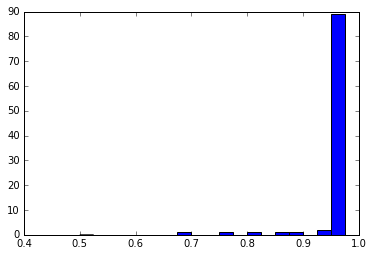

In [9]:
#
# Make a histogram of average correlation values
#

corrmeans = []
for i1,c1 in enumerate(corrdata):
    corrmeans.append(np.mean(c1))

hist = plt.hist(corrmeans, bins=np.arange(0.5,1.0,.025))

In [10]:
colnames_filt = []
for c1 in colnames:
    d = []
    for c2 in colnames:
        d.append(pearsonr(df[c1],df[c2])[0])
    d = np.array(d)
    if np.mean(d) < 0.95:
        print ("Removing ",c1,np.mean(d))
    else:
        colnames_filt.append(c1)
        
colnames = colnames_filt

Removing  Snf2_rep35 0.932471392569
Removing  WT_rep28 0.891720439048
Removing  Snf2_rep13 0.803427905697
Removing  WT_rep25 0.86363576014
Removing  WT_rep21 0.764104671143
Removing  WT_rep22 0.933839516889
Removing  Snf2_rep06 0.691487784223


In [12]:
# now create lists for WT and Snf2 so we can start comparing them

colnames_snf2 = []
colnames_WT = []
colnames_all = []

for c in colnames:
    if c.startswith("Snf2"):
        colnames_snf2.append(c)
        colnames_all.append(c)
    elif c.startswith("WT"):
        colnames_WT.append(c)
        colnames_all.append(c)

In [15]:
#
# time to relook at normalization
#

In [14]:
# create dummy reference = geometric mean across data

df['Gmean'] = gmean(df.loc[:,colnames_all],axis=1)

colnorm = {}

for c in colnames:
    colnorm[c] = np.median((df[c]/df['Gmean']).replace([np.inf, -np.inf], np.nan).dropna())
    
for c in colnames:
    df[c] = df[c]/colnorm[c]

In [17]:
# create new columns that are averages

df['WT_ave'] = df[colnames_WT].mean(axis=1)
df['WT_var'] = df[colnames_WT].var(axis=1)
df['WT_sum'] = df[colnames_WT].sum(axis=1)
df['WT_std'] = df[colnames_WT].std(axis=1)

df['Snf2_ave'] = df[colnames_snf2].mean(axis=1)
df['Snf2_var'] = df[colnames_snf2].var(axis=1)
df['Snf2_sum'] = df[colnames_snf2].sum(axis=1)
df['Snf2_std'] = df[colnames_snf2].std(axis=1)

df['ave'] = df[colnames_all].mean(axis=1)
df['var'] = df[colnames_all].var(axis=1)
df['sum'] = df[colnames_all].sum(axis=1)
df['std'] = df[colnames_all].std(axis=1)

In [18]:
# now do lowess regression on variance

x = np.log(df['ave'])
y = np.log(df['var'])
df['var_low'] = np.exp(lowess(y,x,return_sorted = False))

In [103]:
n1 = float(len(colnames_WT))
n2 = float(len(colnames_snf2))

df['z_score'] = ((df[colnames_WT].mean(axis=1) - df[colnames_snf2].mean(axis=1))/np.sqrt((df['var_low']/n1) + (df['var_low']/n2))).fillna(0)

In [104]:
df['p_value'] = norm.cdf(df['z_score'])

In [108]:
# let's make our cutoff p = .01 with Bonferroni 

p_cut = .01 / len(df)

conditions = [
    (df['p_value'] < p_cut),
    (df['p_value'] > 1.0 - p_cut)
    ]
choices = [-1, 1]
df['diffex'] =  np.select(conditions, choices, default=0)

# diffex is 
# -1 if significantly downregulated
# 0 if unchanged
# 1 if significantly upregulated

In [109]:
#
# look at counts of up and downregulated genes
#

df['diffex'].value_counts()

 0    3809
 1    1515
-1    1361
Name: diffex, dtype: int64

In [128]:
# now lets repeat this for a subsample

k = 3

colnames_WT_t = list(np.random.choice(colnames_WT,k))
colnames_snf2_t = list(np.random.choice(colnames_snf2,k))

df['WT_ave_t'] = df[colnames_WT_t].mean(axis=1)
df['WT_var_t'] = df[colnames_WT_t].var(axis=1)
df['WT_sum_t'] = df[colnames_WT_t].sum(axis=1)


df['Snf2_ave_t'] = df[colnames_snf2_t].mean(axis=1)
df['Snf2_var_t'] = df[colnames_snf2_t].var(axis=1)
df['Snf2_sum_t'] = df[colnames_snf2_t].sum(axis=1)

df['ave_t'] = df[colnames_all].mean(axis=1)
df['var_t'] = df[colnames_all].var(axis=1)
df['sum_t'] = df[colnames_all].sum(axis=1)


x = np.log(df['ave_t'])
y = np.log(df['var_t'])
df['var_t_low'] = np.exp(lowess(y,x,return_sorted = False))

n1 = float(len(colnames_WT_t))
n2 = float(len(colnames_snf2_t))

df['z_score_t'] = ((df['WT_ave_t'] - df['Snf2_ave_t'])/np.sqrt((df['var_t_low']/n1) + (df['var_t_low']/n2))).fillna(0)
df['p_value_t'] = norm.cdf(df['z_score_t'])

p_cut = .01 / len(df)

conditions = [
    (df['p_value_t'] < p_cut),
    (df['p_value_t'] > (1.0 - p_cut))
    ]
choices = [-1, 1]
df['diffex_t'] =  np.select(conditions, choices, default=0)

In [129]:
#
# look at counts of up and downregulated genes
#

df['diffex_t'].value_counts()

 0    6186
 1     402
-1      97
Name: diffex_t, dtype: int64

In [130]:
#
# compare 
#

df.groupby(['diffex','diffex_t']).size().reset_index().rename(columns={0:'count'})

,diffex,diffex_t,count
0,-1,-1,97
1,-1,0,1264
2,0,0,3809
3,1,0,1113
4,1,1,402


In [131]:
# now lets do an experiment
# try a bunch of sample sizes 
# and do several trials for each size

sizes = [2,3,5,10,15,20,30,40]
trials = 3
results = {}

for k in sizes:
    results[k] = []
    for t in range(0,trials):
        
        colnames_WT_t = list(np.random.choice(colnames_WT,k))
        colnames_snf2_t = list(np.random.choice(colnames_snf2,k))

        df['WT_ave_t'] = df[colnames_WT_t].mean(axis=1)
        df['WT_var_t'] = df[colnames_WT_t].var(axis=1)
        df['WT_sum_t'] = df[colnames_WT_t].sum(axis=1)


        df['Snf2_ave_t'] = df[colnames_snf2_t].mean(axis=1)
        df['Snf2_var_t'] = df[colnames_snf2_t].var(axis=1)
        df['Snf2_sum_t'] = df[colnames_snf2_t].sum(axis=1)

        df['ave_t'] = df[colnames_all].mean(axis=1)
        df['var_t'] = df[colnames_all].var(axis=1)
        df['sum_t'] = df[colnames_all].sum(axis=1)


        x = np.log(df['ave_t'])
        y = np.log(df['var_t'])
        df['var_t_low'] = np.exp(lowess(y,x,return_sorted = False))

        n1 = float(len(colnames_WT_t))
        n2 = float(len(colnames_snf2_t))

        df['z_score_t'] = ((df['WT_ave_t'] - df['Snf2_ave_t'])/np.sqrt((df['var_t_low']/n1) + (df['var_t_low']/n2))).fillna(0)
        df['p_value_t'] = norm.cdf(df['z_score_t'])

        p_cut = .01 / len(df)

        conditions = [
            (df['p_value_t'] < p_cut),
            (df['p_value_t'] > 1.0 - p_cut)
            ]
        choices = [-1, 1]
        df['diffex_t'] =  np.select(conditions, choices, default=0)
        
        #
        # this creates a new dataframe with results 
        # diffex is call in all samples
        # diffex_t is call in subsample
        #
        
        results[k].append(df.groupby(['diffex','diffex_t']).size().reset_index().rename(columns={0:'count'}))

In [132]:
# this gets everything out of the results and puts it into a new dataframe

si = {-1:'-',0:'0',1:'+'}

rdata = []

for k in sizes:
    for t in range(0,trials):
        tot = {-1:0,0:0,1:0}
        dyn = {'--':0,'-0':0,'-+':0,
               '0-':0,'00':0,'0+':0,
               '+-':0,'+0':0,'++':0}
        
        for i, r in results[k][t].iterrows():
            dyn[si[r['diffex']] + si[r['diffex_t']]] = r['count']
            tot[r['diffex_t']] += r['count']
            
        ldata = []
        ldata.append(k)
        for tk in [-1,0,1]:
            ldata.append(tot[tk])
        for dk in ['--','-0','-+','0-','00','0+','+-','+0','++']:
            ldata.append(dyn[dk])
        rdata.append(ldata)
        
        
#
# columsn are
# k - subsample size
# -,0,+ - counts of down, unchanged and up in subsample
# the remaining columns are counts of different behaviors comparing two calls
# e.g. ++ means up in both, +0 means up in all data but unchanged in subsample

rdf = pd.DataFrame(data=rdata,columns=['k','-','0','+','--','-0','-+','0-','00','0+','+-','+0','++'])

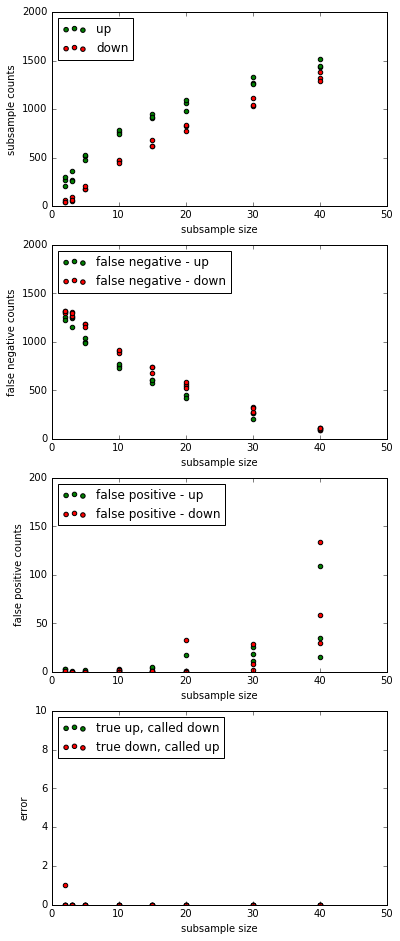

In [155]:
fig, axes = plt.subplots(4,1,figsize=(6,16))

sp = 0
axes[sp].scatter(rdf['k'],rdf['+'],c='g',label='up')
axes[sp].scatter(rdf['k'],rdf['-'],c='r',label='down')
axes[sp].set_xlabel('subsample size')
axes[sp].set_ylabel('subsample counts')
axes[sp].set_xlim(0,50)
axes[sp].set_ylim(0,2000)
axes[sp].legend(loc='upper left')

sp = 1
axes[sp].scatter(rdf['k'],rdf['+0'],c='g',label='false negative - up')
axes[sp].scatter(rdf['k'],rdf['-0'],c='r',label='false negative - down')
axes[sp].set_xlabel('subsample size')
axes[sp].set_ylabel('false negative counts')
axes[sp].set_xlim(0,50)
axes[sp].set_ylim(0,2000)
axes[sp].legend(loc='upper left')

sp = 2
axes[sp].scatter(rdf['k'],rdf['0+'],c='g',label='false positive - up')
axes[sp].scatter(rdf['k'],rdf['0-'],c='r',label='false positive - down')
axes[sp].set_xlabel('subsample size')
axes[sp].set_ylabel('false positive counts')
axes[sp].set_xlim(0,50)
axes[sp].set_ylim(0,200)
axes[sp].legend(loc='upper left')

sp = 3
axes[sp].scatter(rdf['k'],rdf['+-'],c='g',label='true up, called down')
axes[sp].scatter(rdf['k'],rdf['-+'],c='r',label='true down, called up')
axes[sp].set_xlabel('subsample size')
axes[sp].set_ylabel('error')
axes[sp].set_xlim(0,50)
axes[sp].set_ylim(0,10)
axes[sp].legend(loc='upper left')